# **Описание задачи**

В современном мире носимые устройства, такие как фитнес-браслеты, умные часы и различные сенсоры, играют ключевую роль в мониторинге физической активности человека. Эти данные используются в медицинских, спортивных и навигационных приложениях, помогая отслеживать состояние здоровья, уровень нагрузки, а также выявлять потенциальные угрозы безопасности.

В данной задаче предлагается обработка и кластеризация данных, полученных с трех инерциальных измерительных модулей (IMU) и пульсометра. Это позволит автоматически распознавать тип выполняемой физической активности (ходьба, бег, приседания и т. д.), что может быть применено для персонализированного фитнес-трекинга, медицинской диагностики и анализа поведения пользователей.

Исходные данные включают как открытые датасеты, так и собственноручно собранные записи.

# **Описание датасета**

В данной задаче вам предлагается, используя информацию, собранную с помощью трех Инерциальных измерительных модуля (IMU) и пульсометра, сгруппировать данные, которые отображали бы различную физическую активность (бег, ходьба, езда на велосипеде и т.д.)

**Датасет содержит по 54 столбца на строку, столбцы содержат следующие данные:**

1 временная метка (с)

2 частота сердечных сокращений (уд/мин)

3-19 данные с датчиков на руке

20-36 данные с датчиков на груди

37-53 данные с датчиков на лодыжке

**Сенсорные данные IMU содержат следующие столбцы:**

1 температура (°C)

2-4 Данные 3D-ускорения (мс-2), масштаб: ±16g, разрешение: 13 бит

5-7 Данные 3D-ускорения (мс-2), масштаб: ±6g, разрешение: 13 бит*

8-10 данных 3D-гироскопа (рад/с)

11-13 Данные 3D-магнитометра (мкТл)

Подробнее о данных можно прочитать тут: https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring



# **Импорт библиотек**

In [260]:
# Импорт требуемых библиотек для анализа данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт библиотек требуемых для кластеризации
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Вывод фото
from IPython.display import Image

%matplotlib inline

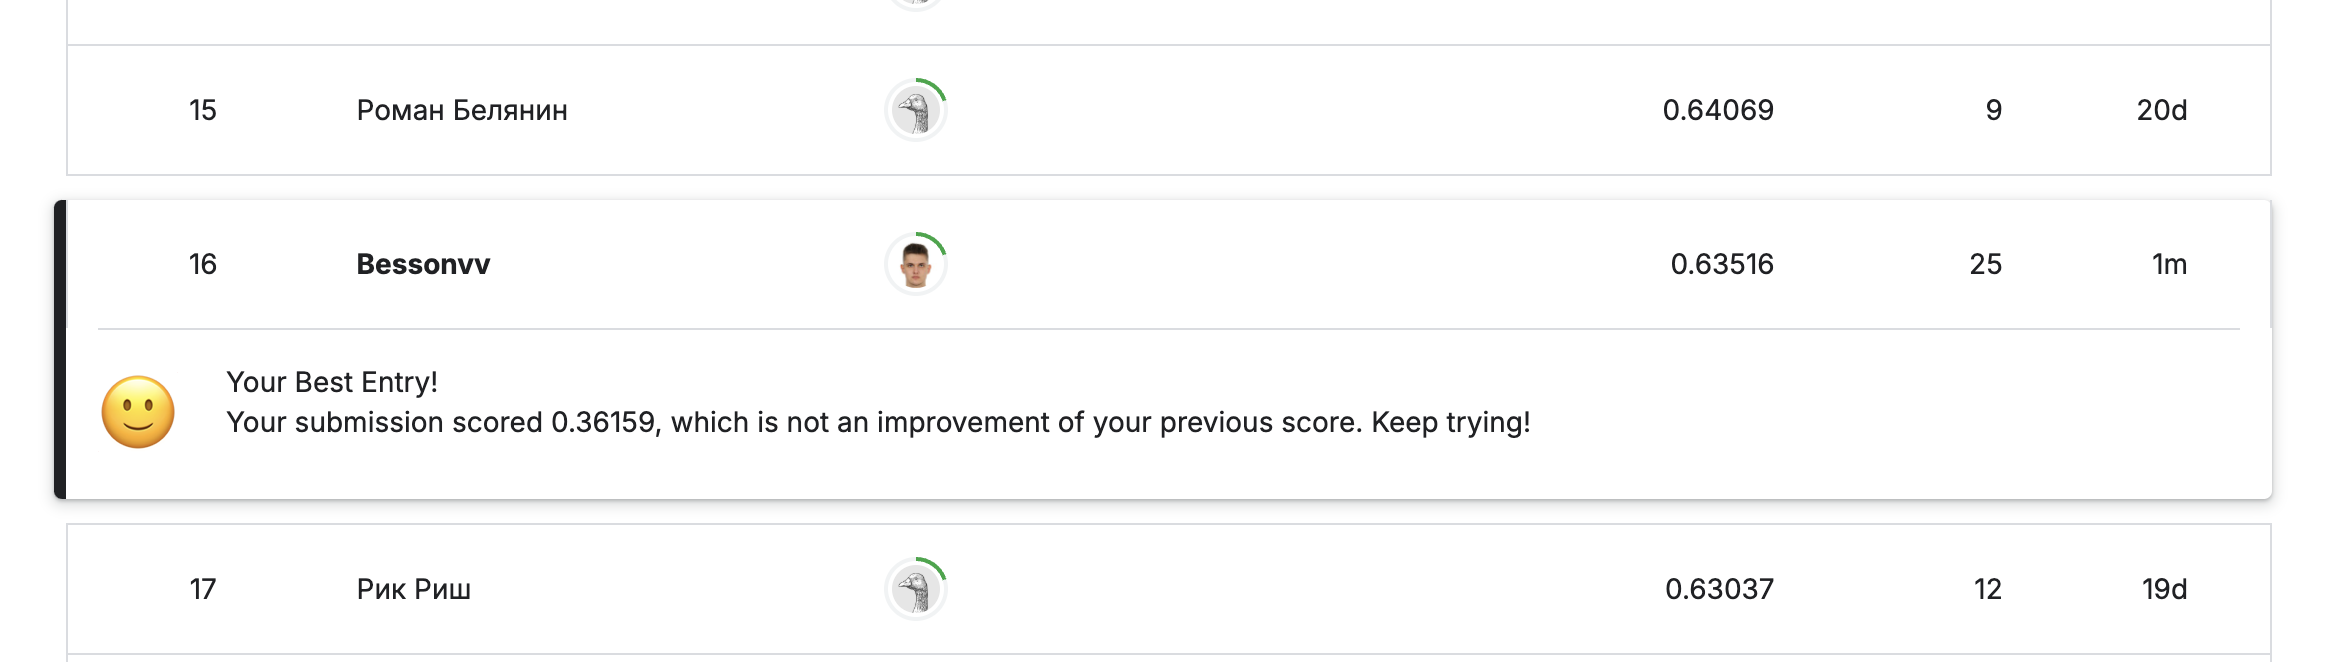

In [261]:
Image('/Users/bessonv/Skillfactory/Анализ данных в Pandas/Снимок экрана 2025-05-10 в 23.34.58.png')

# **Загрузка данных**

In [248]:
# Загрузка датасета
data = pd.read_csv('/Users/bessonv/Skillfactory/Анализ данных в Pandas/Physical_Activity_Monitoring_unlabeled.csv')
display(data.head())
print('В датасете {} объектов и {} признаков.'.format(data.shape[0],data.shape[1]))

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.5447,27.3336,-5.76620,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.8257,-15.7719,-1.31395,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.8171,16.3089,25.29280,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.7418,34.3566,21.32740,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.7798,-3.9981,10.99500,0.171133,-0.748343,0.252988,-0.588807,6


В датасете 534601 объектов и 53 признаков.


# **Исследование и анализ датасета**

In [249]:
missing_values = data.isnull().sum()  # Количество пропусков
total_rows = len(data)  # Общее число строк

# Фильтруем только столбцы с пропусками
missing_data = missing_values[missing_values > 0].to_frame(name="Missing Count")
missing_data["Missing Percentage"] = (missing_data["Missing Count"] / total_rows) * 100

missing_data

,Missing Count,Missing Percentage
handTemperature,4041,0.755891
handAcc16_1,4041,0.755891
handAcc16_2,4041,0.755891
handAcc16_3,4041,0.755891
handAcc6_1,4041,0.755891
handAcc6_2,4041,0.755891
handAcc6_3,4041,0.755891
handGyro1,4041,0.755891
handGyro2,4041,0.755891
handGyro3,4041,0.755891


Пропуски в данных достигают максимум 0.75 %, заменим их средним значением.

# **Очистка данных**

In [250]:
col_missing = ['chestTemperature', 'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1', 'chestMagne2', 'chestMagne3', 'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4', 'ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1', 'ankleMagne2', 'ankleMagne3', 'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

for i in data.columns:
    data[i] = data[i].fillna(data[i].mean())

data.isna().sum()

timestamp            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3          0
ankleGyro1           0
ankleGyro2 

Заменили пропуски на среднее значение в собственном столбце

# **Feature engineering**

In [251]:
# По x, y, z кооридантам датчиков найдем их векторы
def xyz_to_vec(df):
    # Hand векторы
    df['v_handAcc16']=np.sqrt(df['handAcc16_1']**2+df['handAcc16_2']**2+df['handAcc16_3']**2)
    df['v_handAcc6']=np.sqrt(df['handAcc6_1']**2+df['handAcc6_2']**2+df['handAcc6_3']**2)
    df['v_handGyro']=np.sqrt(df['handGyro1']**2+df['handGyro2']**2+df['handGyro3']**2)
    df['v_handMagne']=np.sqrt(df['handMagne1']**2+df['handMagne2']**2+df['handMagne3']**2)

    # Chest векторы
    df['v_chestAcc16']=np.sqrt(df['chestAcc16_1']**2+df['chestAcc16_2']**2+df['chestAcc16_3']**2)
    df['v_chestAcc6']=np.sqrt(df['chestAcc6_1']**2+df['chestAcc6_2']**2+df['chestAcc6_3']**2)
    df['v_chestGyro']=np.sqrt(df['chestGyro1']**2+df['chestGyro2']**2+df['chestGyro3']**2)
    df['v_chestMagne']=np.sqrt(df['chestMagne1']**2+df['chestMagne2']**2+df['chestMagne3']**2)

    # Ankle векторы 
    df['v_ankleAcc16']=np.sqrt(df['ankleAcc16_1']**2+df['ankleAcc16_2']**2+df['ankleAcc16_3']**2)
    df['v_ankleAcc6']=np.sqrt(df['ankleAcc6_1']**2+df['ankleAcc6_2']**2+df['ankleAcc6_3']**2)
    df['v_ankleGyro']=np.sqrt(df['ankleGyro1']**2+df['ankleGyro2']**2+df['ankleGyro3']**2)
    df['v_ankleMagne']=np.sqrt(df['ankleMagne1']**2+df['ankleMagne2']**2+df['ankleMagne3']**2)

    df.drop(columns=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
                     'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
                     'handGyro1', 'handGyro2', 'handGyro3', 
                     'handMagne1', 'handMagne2', 'handMagne3', 
                     'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                     'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
                     'chestGyro1', 'chestGyro2', 'chestGyro3',
                     'chestMagne1', 'chestMagne2', 'chestMagne3',
                     'ankleAcc16_1', 'ankleAcc16_1', 'ankleAcc16_1',
                     'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
                     'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
                     'ankleMagne1', 'ankleMagne2', 'ankleMagne3'
                     ], inplace=True)
    return df

data = xyz_to_vec(data)

data.head()

,timestamp,handTemperature,handOrientation1,handOrientation2,handOrientation3,handOrientation4,chestTemperature,chestOrientation1,chestOrientation2,chestOrientation3,...,v_handGyro,v_handMagne,v_chestAcc16,v_chestAcc6,v_chestGyro,v_chestMagne,v_ankleAcc16,v_ankleAcc6,v_ankleGyro,v_ankleMagne
0,252.75,34.8750,0.561813,-0.218644,0.359836,0.712095,36.6250,0.987675,-0.081231,-0.009229,...,0.022347,34.425872,9.476392,9.877675,0.039630,48.756258,10.130236,9.819462,0.059178,31.494810
1,3652.45,29.7500,0.884964,-0.281047,-0.145657,0.341518,34.6875,0.155581,-0.908072,-0.388069,...,0.393683,55.213200,12.175270,11.229790,0.475300,43.098251,6.958333,8.182519,1.934298,36.441815
2,504.76,34.3750,0.535655,0.564385,0.371967,-0.506146,37.6250,0.721119,-0.680477,0.090302,...,0.048141,29.232354,9.816755,9.797023,0.041782,26.697400,9.990753,9.828768,0.066698,35.493509
3,2801.61,31.9375,0.648205,0.540984,-0.282560,-0.455332,36.5000,0.367155,-0.663333,0.553109,...,2.508222,49.067975,12.559313,13.233767,0.504263,39.066927,14.122803,18.410660,4.589847,48.480489
4,441.01,33.5000,0.769041,-0.442364,0.232331,0.398638,35.8125,0.735751,-0.666812,0.086031,...,0.034214,30.426190,9.779122,9.851332,0.063361,26.316878,9.957803,9.869706,0.031659,21.283705


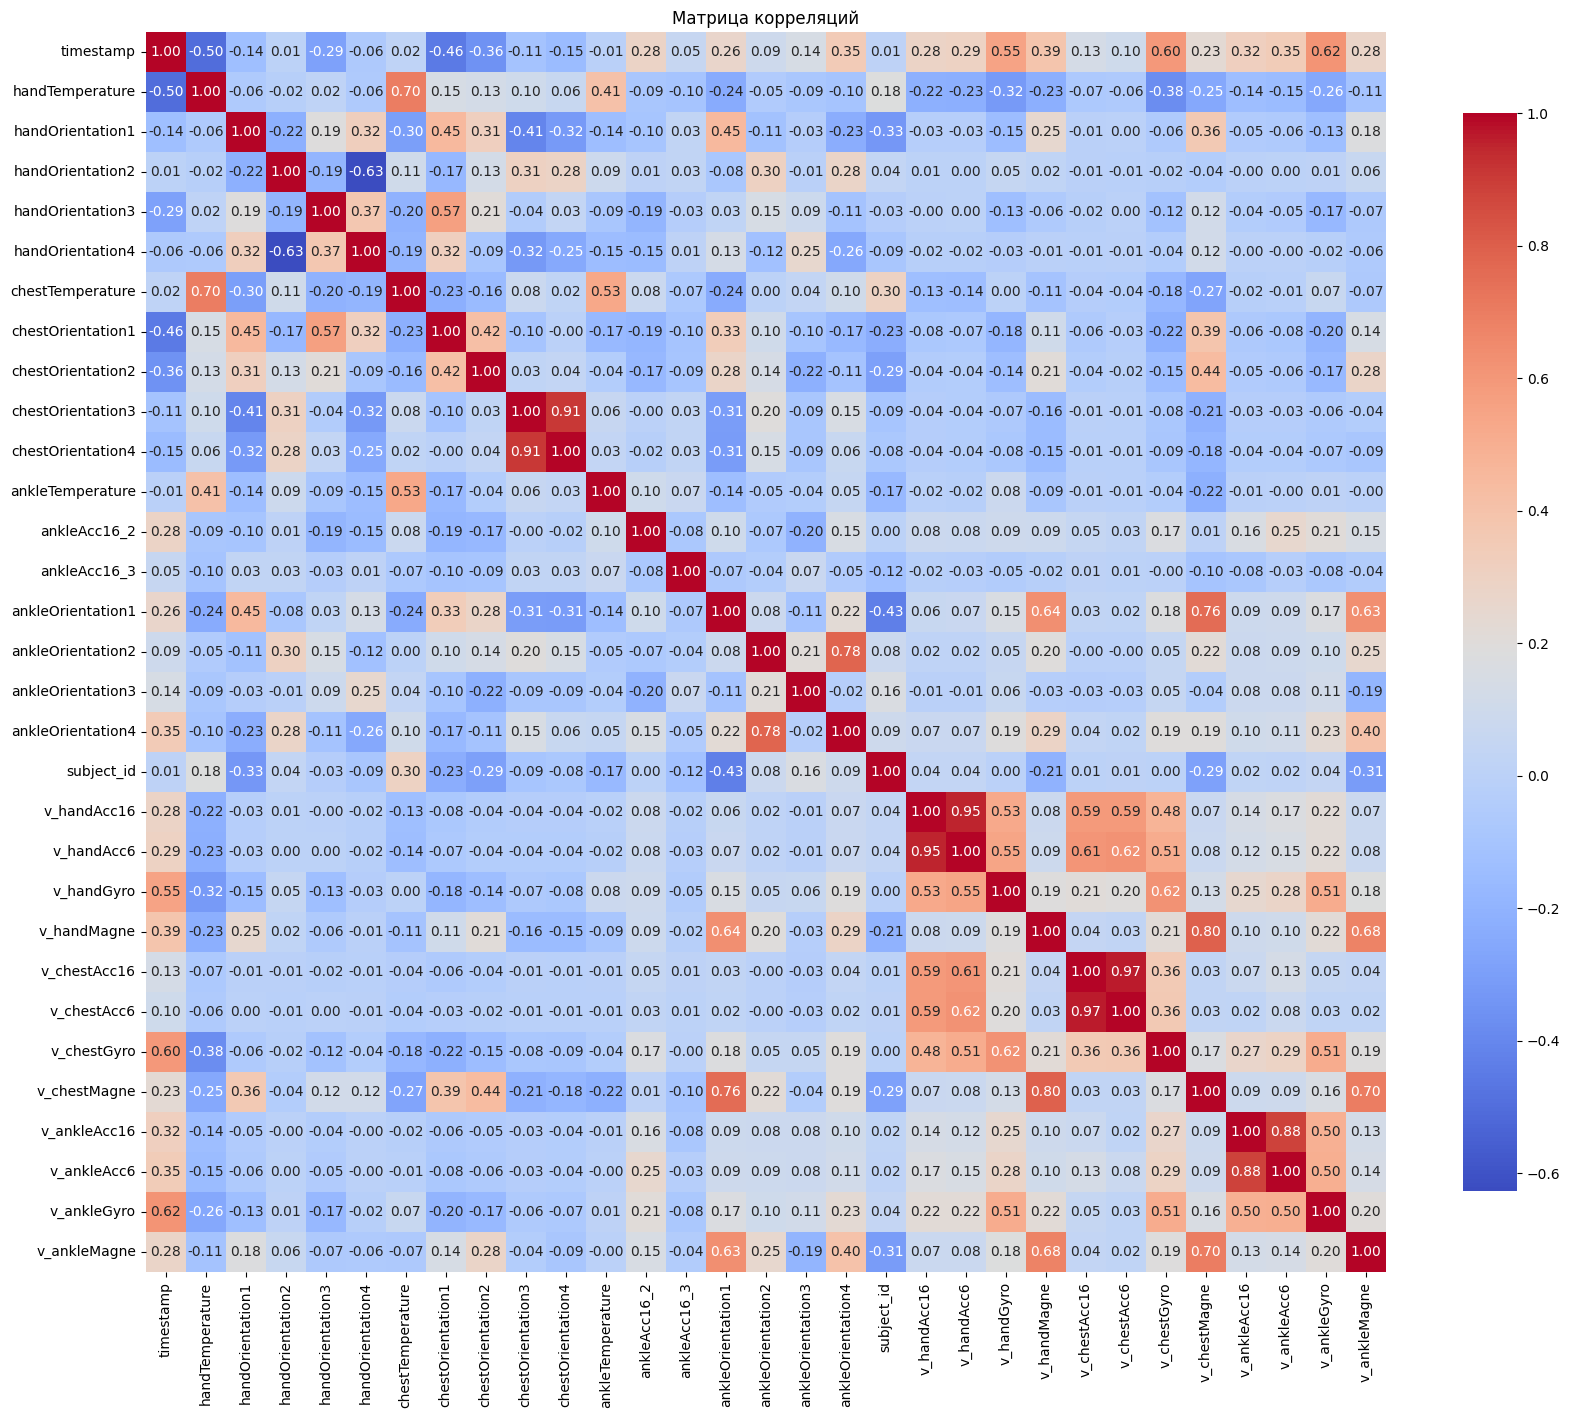

In [252]:
# Кореляционная матрица
corr = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .7})
plt.title("Матрица корреляций")
plt.show()

Уменьшили датасет с помощью замены значений с датчиков акселерометра, гироскопа, магнитометра на собственный модуль вектора.

# **Отбор признаков**

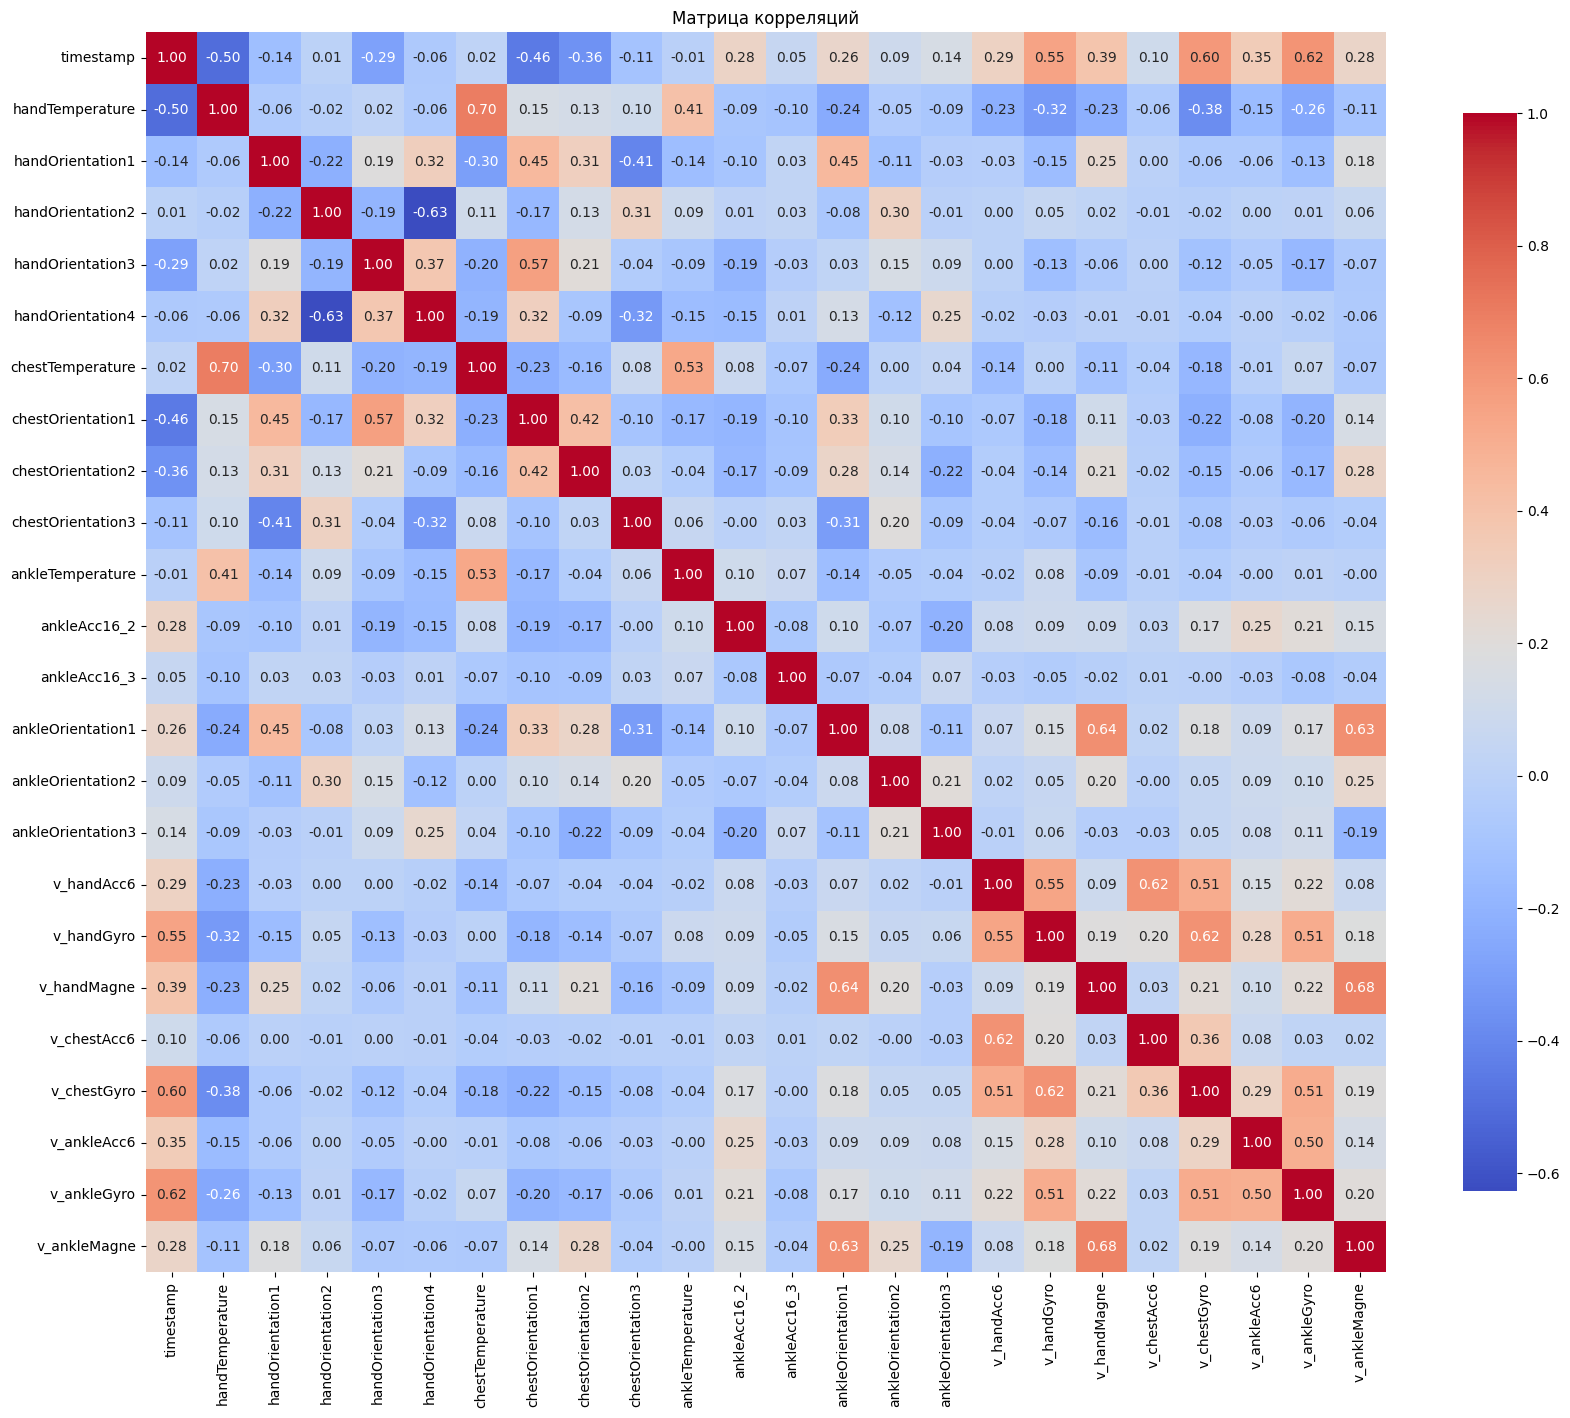

In [253]:
data = data.drop(columns=['chestOrientation4', 'ankleOrientation4','v_handAcc16','v_chestAcc16','v_ankleAcc16', 'v_chestMagne', 'subject_id'])
corr = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .7})
plt.title("Матрица корреляций")
plt.show()

Признаки с корреляцией >0.8 удалены.

# **Обучение нескольких моделей, их сравнение**

## **K-mean**

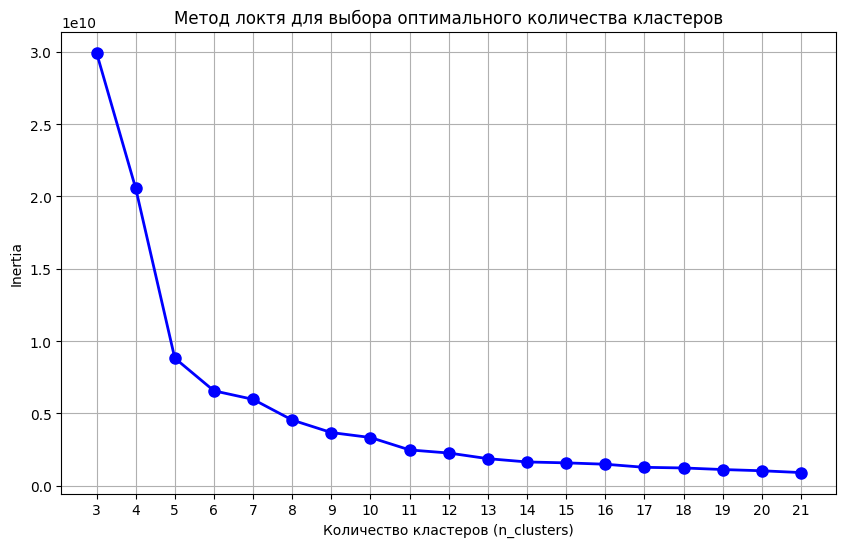

In [254]:
# 1 шаг: Найдем число кластеров методом локтя
inertia_df = pd.DataFrame(data=[], index=range(3, 12), columns=['inertia'])

for n_clusters in range(3, 22):
    clusterer = KMeans(n_clusters=n_clusters,  random_state=42)
    cluster_labels = clusterer.fit_predict(data)

    # inertia
    inertia_df.loc[n_clusters] = clusterer.inertia_

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(inertia_df.index, inertia_df['inertia'], 'bo-', linewidth=2, markersize=8)
plt.title('Метод локтя для выбора оптимального количества кластеров')
plt.xlabel('Количество кластеров (n_clusters)')
plt.ylabel('Inertia')
plt.grid(True)
plt.xticks(inertia_df.index)  # Отображаем все значения n_clusters как деления на оси data
plt.show()

Остановимся на значении 7, так как переход самый резкий.

In [ ]:
# Шаг 2: Обучение K-means
n_clusters = 7

clusterer = KMeans(n_clusters=n_clusters, max_iter=10000)

clusters= clusterer.fit_predict(data)

Методом подбора выяснили, что лучшим количеством итераций является 10000.

# **Выгрузка данных**

In [257]:
# Шаг 1: Получаем уникальные метки
unique_clusters = np.unique(clusters)

# Шаг 2: Создаем маппинг от старых меток к новым (1, 2, 3...)
mapping = {label: i+1 for i, label in enumerate(unique_clusters)}

# Шаг 3: Перенумеруем кластеры
mapped_clusters = np.vectorize(mapping.get)(clusters)

# Шаг 4: Формируем submission
submission = pd.DataFrame({
    'Index': np.arange(0, len(mapped_clusters)),
    'activityID': mapped_clusters
})

# Сохраняем файл
submission.to_csv('submission.csv', index=False)

print("Файл сохранён:")
print(submission.head())

Файл сохранён:
   Index  activityID
0      0           5
1      1           3
2      2           1
3      3           4
4      4           1
